# 0. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE

# 1. Load Data

In [ ]:
TRAIN_FILE_PATH = '/content/drive/My Drive/IND_ability_train.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/IND_ability_test.csv'

In [ ]:
df_train = pd.read_csv(TRAIN_FILE_PATH, usecols=['smiles', 'label'])
smiles_train = df_train['smiles'].tolist()
labels_train = df_train['label'].tolist()
df_test = pd.read_csv(TEST_FILE_PATH, usecols=['smiles', 'label'])
smiles_test = df_test['smiles'].tolist()
labels_test = df_test['label'].tolist()

print(f"Loaded {len(smiles_train)} training SMILES, {len(smiles_test)} test SMILES.")

Loaded 24597 training SMILES, 2732 test SMILES.


# 2. Tokenization

In [ ]:
def tokenize_smiles(smiles_str):
    """
    Convert a SMILES string to a list of single-character tokens.
    e.g., 'CC(=O)' -> ['C','C','(','=','O',')']
    """
    return list(smiles_str.strip())

In [ ]:
# Tokenize train/test sets
tokenized_train = [tokenize_smiles(s) for s in smiles_train]
tokenized_test = [tokenize_smiles(s) for s in smiles_test]

# 3. Build Vocabulary

In [ ]:
def build_vocab(tokenized_data):
    """
    Takes a list of token lists and builds:
      - token_to_idx: dict mapping token -> int
      - idx_to_token: dict mapping int -> token
    """
    token_freq = defaultdict(int)
    # print(token_freq)

    # Count frequencies across all SMILES
    for tokens in tokenized_data:
        for t in tokens:
            token_freq[t] += 1
    # print(token_freq)

    # Sort tokens by descending frequency
    sorted_tokens = sorted(token_freq.keys(), key=lambda x: -token_freq[x])

    token_to_idx = {}
    idx_to_token = {}

    for i, token in enumerate(sorted_tokens):
        token_to_idx[token] = i
        idx_to_token[i] = token

    return token_to_idx, idx_to_token

In [ ]:
# Build vocab from the TRAIN set only
token_to_idx, idx_to_token = build_vocab(tokenized_train)
vocab_size = len(token_to_idx)

print(f"Vocab size = {vocab_size}")

Vocab size = 43


# 4. Create SKIP-GRAM Pairs

In [ ]:
def generate_skipgram_pairs(tokenized_data, token_to_idx, window_size=2):
    """
    Creates (target, context) pairs for skip-gram training.
    For each token in a SMILES, we take 'window_size' tokens to the left
    and right as its context (if they exist).
    """
    pairs = []

    for tokens in tokenized_data:
        indices = [token_to_idx[t] for t in tokens if t in token_to_idx]
        for i, target_idx in enumerate(indices):
            # Identify context positions
            start = max(0, i - window_size)
            end   = min(len(indices), i + window_size + 1)

            for j in range(start, end):
                if j != i:
                    context_idx = indices[j]
                    pairs.append((target_idx, context_idx))

    return pairs

In [ ]:
skipgram_pairs_train = generate_skipgram_pairs(tokenized_train, token_to_idx, window_size=2)
print(f"Number of (target, context) pairs in training set: {len(skipgram_pairs_train)}")

Number of (target, context) pairs in training set: 5252830


# 5. Define SKIP-GRAM Model (with Negative Sampling)

In [ ]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        """
        We maintain two embeddings:
          - embedding_v: for 'target' words
          - embedding_u: for 'context' words
        """
        super(SkipGramNegativeSampling, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding_v = nn.Embedding(vocab_size, embedding_dim)  # target embedding
        self.embedding_u = nn.Embedding(vocab_size, embedding_dim)  # context embedding

        nn.init.xavier_uniform_(self.embedding_v.weight)
        nn.init.xavier_uniform_(self.embedding_u.weight)

    def forward(self, target_idxs, context_idxs, negative_idxs):
        """
        Inputs:
          target_idxs: (batch_size)
          context_idxs: (batch_size)
          negative_idxs: (batch_size, K) => K negative samples per target
        Returns:
          pos_score: (batch_size)   => dot(target, context)
          neg_score: (batch_size,K) => dot(target, negative_k)
        """
        # Retrieve embeddings for targets and contexts
        v = self.embedding_v(target_idxs)       # (batch_size, embed_dim)
        u = self.embedding_u(context_idxs)      # (batch_size, embed_dim)

        # Positive score
        pos_score = torch.sum(v * u, dim=1)     # dot product row-wise => (batch_size)

        # Negative embeddings => shape (batch_size, K, embed_dim)
        neg_u = self.embedding_u(negative_idxs)

        # Expand v for broadcasting => (batch_size, 1, embed_dim)
        v = v.unsqueeze(1)
        # Dot with each negative embedding => (batch_size, K)
        neg_score = torch.sum(v * neg_u, dim=2)

        return pos_score, neg_score

In [ ]:
def negative_sampling_loss(pos_score, neg_score):
    """
    Negative sampling loss:
      - Maximize log(sigmoid(pos_score))
      - Maximize log(sigmoid(-neg_score)) for negative samples
    """
    # pos_score: (batch_size)
    # neg_score: (batch_size, K)

    # Avoid log(0)
    eps = 1e-9

    # Positive part: log(sigmoid(pos_score))
    pos_loss = -torch.log(torch.sigmoid(pos_score) + eps)

    # Negative part: sum of log(sigmoid(-neg_score)) over K negative samples
    neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_score) + eps), dim=1)

    return torch.mean(pos_loss + neg_loss)

# 6. Training The Model

In [ ]:
# Hyperparameters
embedding_dim   = 50   # size of embedding vectors
epochs          = 5
batch_size      = 64
neg_sample_size = 5    # K negative samples per example
learning_rate   = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SkipGramNegativeSampling(vocab_size, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert skipgram pairs to numpy array for easy mini-batching
pairs_arr = np.array(skipgram_pairs_train)
num_batches = len(pairs_arr) // batch_size

print("Starting training...")
for epoch in range(epochs):
    np.random.shuffle(pairs_arr)
    total_loss = 0.0
    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for i in progress_bar:
        batch_pairs = pairs_arr[i * batch_size: (i + 1) * batch_size]

        # Convert batch data to tensors and move to GPU
        target_idxs = torch.LongTensor(batch_pairs[:, 0]).to(device)
        context_idxs = torch.LongTensor(batch_pairs[:, 1]).to(device)

        # Sample negative examples
        negative_idxs = []
        for _ in range(batch_size):
            negs = np.random.choice(vocab_size, neg_sample_size, replace=False)
            negative_idxs.append(negs)
        negative_idxs = torch.LongTensor(negative_idxs).to(device)

        pos_score, neg_score = model(target_idxs, context_idxs, negative_idxs)
        loss = negative_sampling_loss(pos_score, neg_score)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {avg_loss:.4f}")

Using device: cuda
Starting training...


Epoch 1/5 completed. Avg Loss: 1.5321


Epoch 2/5 completed. Avg Loss: 1.5299


Epoch 3/5 completed. Avg Loss: 1.5292


Epoch 4/5 completed. Avg Loss: 1.5289


Epoch 5/5 completed. Avg Loss: 1.5288


# 7. Extract Word2Vec Embeddings

In [ ]:
def smiles_to_embedding(smiles_str, model, token_to_idx):
    """
    Converts a SMILES string to an average of its token embeddings
    (character-level).
    Returns a numpy array of shape (embedding_dim,).
    """
    tokens = tokenize_smiles(smiles_str)
    vectors = []
    for t in tokens:
        if t in token_to_idx:
            idx = token_to_idx[t]
            # Extract the learned target embedding
            emb = model.embedding_v.weight[idx].detach().cpu().numpy()
            vectors.append(emb)

    if len(vectors) == 0:
        # If no valid tokens found, return zero vector
        return np.zeros(model.embedding_dim)
    else:
        return np.mean(vectors, axis=0)

In [ ]:
train_embeddings = []
for s in smiles_train:
    vec = smiles_to_embedding(s, model, token_to_idx)
    train_embeddings.append(vec)

test_embeddings = []
for s in smiles_test:
    vec = smiles_to_embedding(s, model, token_to_idx)
    test_embeddings.append(vec)

print(f"Train set embeddings shape: {len(train_embeddings)} x {len(train_embeddings[0]) if train_embeddings else 'unknown'}")
print(f"Test set embeddings shape:  {len(test_embeddings)} x {len(test_embeddings[0]) if test_embeddings else 'unknown'}")

Train set embeddings shape: 24597 x 50
Test set embeddings shape:  2732 x 50


In [ ]:
train_embeddings = np.array(train_embeddings)  # shape: (num_train, embedding_dim)
test_embeddings  = np.array(test_embeddings)   # shape: (num_test, embedding_dim)

# Convert labels to numpy if not already
labels_train_np = np.array(labels_train)
labels_test_np  = np.array(labels_test)

# Split test into validation and final test sets (50% val, 50% test)
val_embeddings, final_test_embeddings, val_labels, final_test_labels = train_test_split(
    test_embeddings, labels_test_np, test_size=0.5, random_state=42, stratify=labels_test_np
)

In [ ]:
# Apply SMOTE to training set
smote = SMOTE(random_state=42)
train_embeddings_resampled, labels_train_resampled = smote.fit_resample(train_embeddings, labels_train_np)

print(f"Original class distribution: {np.bincount(labels_train_np)}")
print(f"Resampled class distribution: {np.bincount(labels_train_resampled)}")

Original class distribution: [16155  8442]
Resampled class distribution: [16155 16155]


# 8. Define a DATASET/LOADER For The MLP

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
train_dataset = EmbeddingDataset(train_embeddings, labels_train_np)
resampled_dataset = EmbeddingDataset(train_embeddings_resampled, labels_train_resampled)
# test_dataset  = EmbeddingDataset(test_embeddings,  labels_test_np)
val_dataset = EmbeddingDataset(val_embeddings, val_labels)
final_test_dataset = EmbeddingDataset(final_test_embeddings, final_test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
resampled_loader = DataLoader(resampled_dataset, batch_size=32, shuffle=True)
# test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

# 9. Define The MLP Classifier & Train


In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 8), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x).view(-1)  # shape: (batch,)

In [ ]:
def train_and_evaluate_model(train_loader, val_loader, test_loader, input_dim, epochs=20, lr=0.001, plot_loss=True):
    model = MLPClassifier(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            loss = criterion(preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(batch_x)
        train_losses.append(total_loss / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                val_loss += loss.item() * len(batch_x)
        val_losses.append(val_loss / len(val_loader.dataset))

        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    # Plot loss
    if plot_loss:
        plt.figure(figsize=(7, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            probs = model(batch_x).cpu()
            preds = (probs >= 0.5).float()

            all_probs.extend(probs.numpy())
            all_preds.extend(preds.numpy())
            all_targets.extend(batch_y.numpy())

    # Metrics
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)

    print("\nFinal Evaluation:")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC AUC      : {roc:.4f}")
    # Confusion Matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
    }

Training on original imbalanced data:


Epoch 1 | Train Loss: 0.6269 | Val Loss: 0.6093


Epoch 2 | Train Loss: 0.6062 | Val Loss: 0.6030


Epoch 3 | Train Loss: 0.5982 | Val Loss: 0.5982


Epoch 4 | Train Loss: 0.5927 | Val Loss: 0.6007


Epoch 5 | Train Loss: 0.5867 | Val Loss: 0.5912


Epoch 6 | Train Loss: 0.5839 | Val Loss: 0.5838


Epoch 7 | Train Loss: 0.5785 | Val Loss: 0.5841


Epoch 8 | Train Loss: 0.5761 | Val Loss: 0.5791


Epoch 9 | Train Loss: 0.5677 | Val Loss: 0.5854


Epoch 10 | Train Loss: 0.5658 | Val Loss: 0.5717


Epoch 11 | Train Loss: 0.5600 | Val Loss: 0.5627


Epoch 12 | Train Loss: 0.5567 | Val Loss: 0.5607


Epoch 13 | Train Loss: 0.5530 | Val Loss: 0.5702


Epoch 14 | Train Loss: 0.5502 | Val Loss: 0.5606


Epoch 15 | Train Loss: 0.5488 | Val Loss: 0.5737


Epoch 16 | Train Loss: 0.5441 | Val Loss: 0.5648


Epoch 17 | Train Loss: 0.5435 | Val Loss: 0.5527


Epoch 18 | Train Loss: 0.5422 | Val Loss: 0.5704


Epoch 19 | Train Loss: 0.5414 | Val Loss: 0.5509


Epoch 20 | Train Loss: 0.5340 | Val Loss: 0.5623


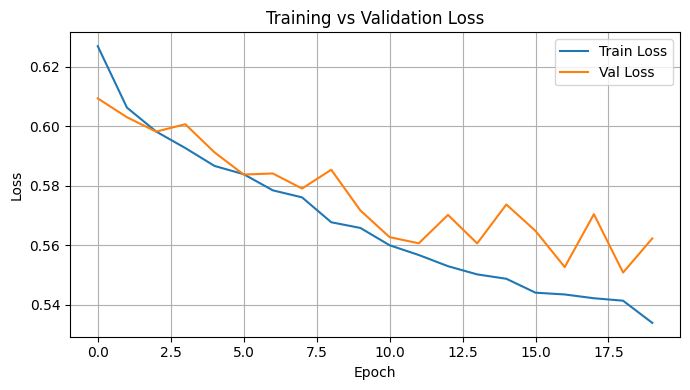


Final Evaluation:
Accuracy     : 0.7328
Precision    : 0.6156
Recall       : 0.6038
F1 Score     : 0.6096
ROC AUC      : 0.7949


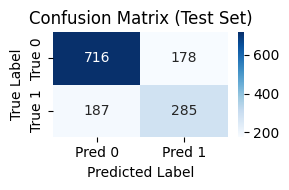


 Training on SMOTE-resampled data:


Epoch 1 | Train Loss: 0.6681 | Val Loss: 0.6607


Epoch 2 | Train Loss: 0.6497 | Val Loss: 0.6409


Epoch 3 | Train Loss: 0.6378 | Val Loss: 0.6143


Epoch 4 | Train Loss: 0.6274 | Val Loss: 0.6361


Epoch 5 | Train Loss: 0.6203 | Val Loss: 0.6275


Epoch 6 | Train Loss: 0.6103 | Val Loss: 0.6381


Epoch 7 | Train Loss: 0.6035 | Val Loss: 0.6096


Epoch 8 | Train Loss: 0.5988 | Val Loss: 0.6286


Epoch 9 | Train Loss: 0.5931 | Val Loss: 0.5973


Epoch 10 | Train Loss: 0.5865 | Val Loss: 0.6096


Epoch 11 | Train Loss: 0.5819 | Val Loss: 0.5918


Epoch 12 | Train Loss: 0.5767 | Val Loss: 0.5926


Epoch 13 | Train Loss: 0.5715 | Val Loss: 0.6354


Epoch 14 | Train Loss: 0.5677 | Val Loss: 0.5822


Epoch 15 | Train Loss: 0.5611 | Val Loss: 0.5929


Epoch 16 | Train Loss: 0.5582 | Val Loss: 0.5748


Epoch 17 | Train Loss: 0.5535 | Val Loss: 0.5949


Epoch 18 | Train Loss: 0.5501 | Val Loss: 0.5885


Epoch 19 | Train Loss: 0.5461 | Val Loss: 0.5669


Epoch 20 | Train Loss: 0.5415 | Val Loss: 0.5816


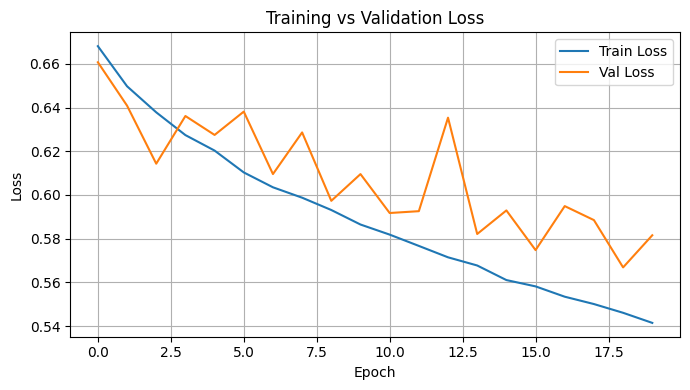


Final Evaluation:
Accuracy     : 0.7123
Precision    : 0.5659
Recall       : 0.7182
F1 Score     : 0.6331
ROC AUC      : 0.7861


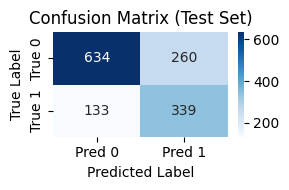

In [ ]:
print("Training on original imbalanced data:")
metrics_baseline = train_and_evaluate_model(train_loader, val_loader, final_test_loader, embedding_dim)
print("==============================================================================")
print("\n Training on SMOTE-resampled data:")
metrics_smote = train_and_evaluate_model(resampled_loader, val_loader, final_test_loader, embedding_dim)

In [ ]:
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "Baseline": [metrics_baseline["accuracy"], metrics_baseline["precision"],
                 metrics_baseline["recall"], metrics_baseline["f1"], metrics_baseline["roc_auc"]],
    "SMOTE": [metrics_smote["accuracy"], metrics_smote["precision"],
              metrics_smote["recall"], metrics_smote["f1"], metrics_smote["roc_auc"]]
})

print(metrics_df)

      Metric  Baseline     SMOTE
0   Accuracy  0.732796  0.712299
1  Precision  0.615551  0.565943
2     Recall  0.603814  0.718220
3   F1 Score  0.609626  0.633053
4    ROC AUC  0.794854  0.786131
